In [109]:
!pip install textblob

Defaulting to user installation because normal site-packages is not writeable


In [145]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------ 152.1/152.1 kB 349.4 kB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay


In [111]:
df=pd.read_csv('vaccination_tweets.csv')
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                11020 non-null  int64 
 1   user_name         11020 non-null  object
 2   user_location     8750 non-null   object
 3   user_description  10341 non-null  object
 4   user_created      11020 non-null  object
 5   user_followers    11020 non-null  int64 
 6   user_friends      11020 non-null  int64 
 7   user_favourites   11020 non-null  int64 
 8   user_verified     11020 non-null  bool  
 9   date              11020 non-null  object
 10  text              11020 non-null  object
 11  hashtags          8438 non-null   object
 12  source            11019 non-null  object
 13  retweets          11020 non-null  int64 
 14  favorites         11020 non-null  int64 
 15  is_retweet        11020 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory usage: 1.2+ MB


In [113]:
df.isnull().sum()

id                     0
user_name              0
user_location       2270
user_description     679
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

In [114]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [115]:
df=df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],axis=1)
df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


## Data Preporocessing
1: Lower Case
2:Removing Special character
3:Removing Stop words
4:Toeknising'
5:Stemming

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11020 non-null  object
dtypes: object(1)
memory usage: 86.2+ KB


In [117]:
def data_preprocessing(text):
    text=text.lower()
    text=re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)#to remove the urls
    text= re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_token=word_tokenize(text)
    stop_words=set(stopwords.words('english'))
    filtered_text=[w for w in text_token if w not in stop_words]
    return ' '.join(filtered_text)

In [118]:
df.text=df['text'].apply(data_preprocessing)

In [119]:
df['text'][0]

'folks said daikon paste could treat cytokine storm pfizerbiontech'

In [120]:
print(df['text'].iloc[0],"\n")

folks said daikon paste could treat cytokine storm pfizerbiontech 



In [121]:
df=df.drop_duplicates('text')
df

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine borisjohnson matthancock ...
...,...
11014,ruvanw gmalavige chandi2012 already 3rd pfizer...
11015,number covid19 cases today 17 november 2021 re...
11017,number covid19 cases today 16 november 2021 re...
11018,pfizerbiontech developed new pill paxlovid inc...


In [122]:
stemmer=PorterStemmer()
def stemming(data):
    text=[stemmer.stem(word) for word in data]
    return data

In [123]:
df['text']=df['text'].apply(lambda x:stemming(x))

In [124]:
df['text'][0]

'folks said daikon paste could treat cytokine storm pfizerbiontech'

In [126]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [127]:
df['polarity']=df['text'].apply(polarity)

In [128]:
df.head()

,text,polarity
0,folks said daikon paste could treat cytokine s...,0.0
1,world wrong side history year hopefully bigges...,-0.5
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0
3,facts immutable senator even youre ethically s...,0.1
4,explain need vaccine borisjohnson matthancock ...,0.0


In [131]:
def sentiment(label):
    if label<0:
        return 'Negative'
    elif label==0:
        return 'Neutral'
    elif label >0:
        return 'Positive'

In [132]:
df['sentiment']=df['polarity'].apply(sentiment)

In [133]:
df.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
1,world wrong side history year hopefully bigges...,-0.5,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.0,Neutral
3,facts immutable senator even youre ethically s...,0.1,Positive
4,explain need vaccine borisjohnson matthancock ...,0.0,Neutral


## Exploratory Data Analysis

<Axes: xlabel='sentiment', ylabel='count'>

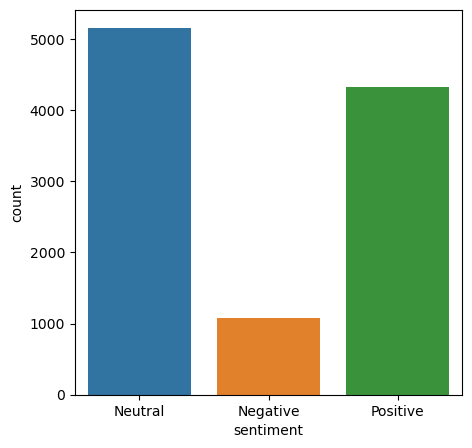

In [134]:
fig= plt.figure(figsize=(5,5))
sns.countplot(x='sentiment',data =df)

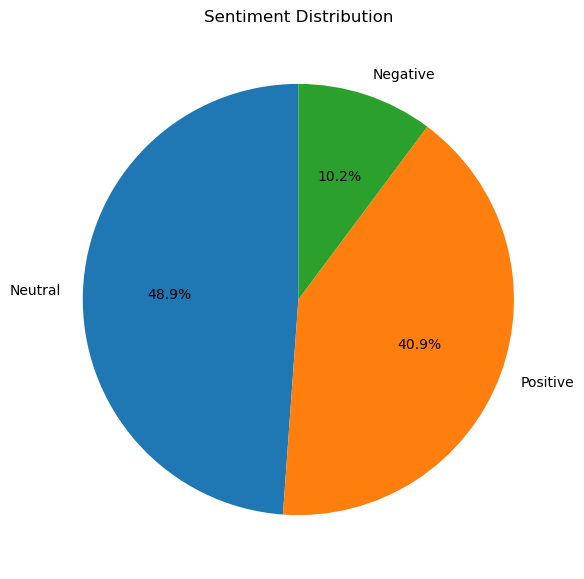

In [140]:
fig=plt.figure(figsize=(7,7))
tags=df['sentiment'].value_counts()
plt.pie(tags,labels=tags.index, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.show()

In [141]:
pos_tweet=df[df.sentiment=='Positive']
pos_tweet=pos_tweet.sort_values(['polarity'],ascending=False)
pos_tweet.head()

,text,polarity,sentiment
9317,best way get merrygoround pfizer pfizerbiontec...,1.0,Positive
2340,applying emotion pfizerbiontech based best evi...,1.0,Positive
6295,pfizer jab morning efficient wellorganised tha...,1.0,Positive
5041,get art printed awesome products support redbu...,1.0,Positive
1055,already vaccinated getting vaccine soon plan t...,1.0,Positive


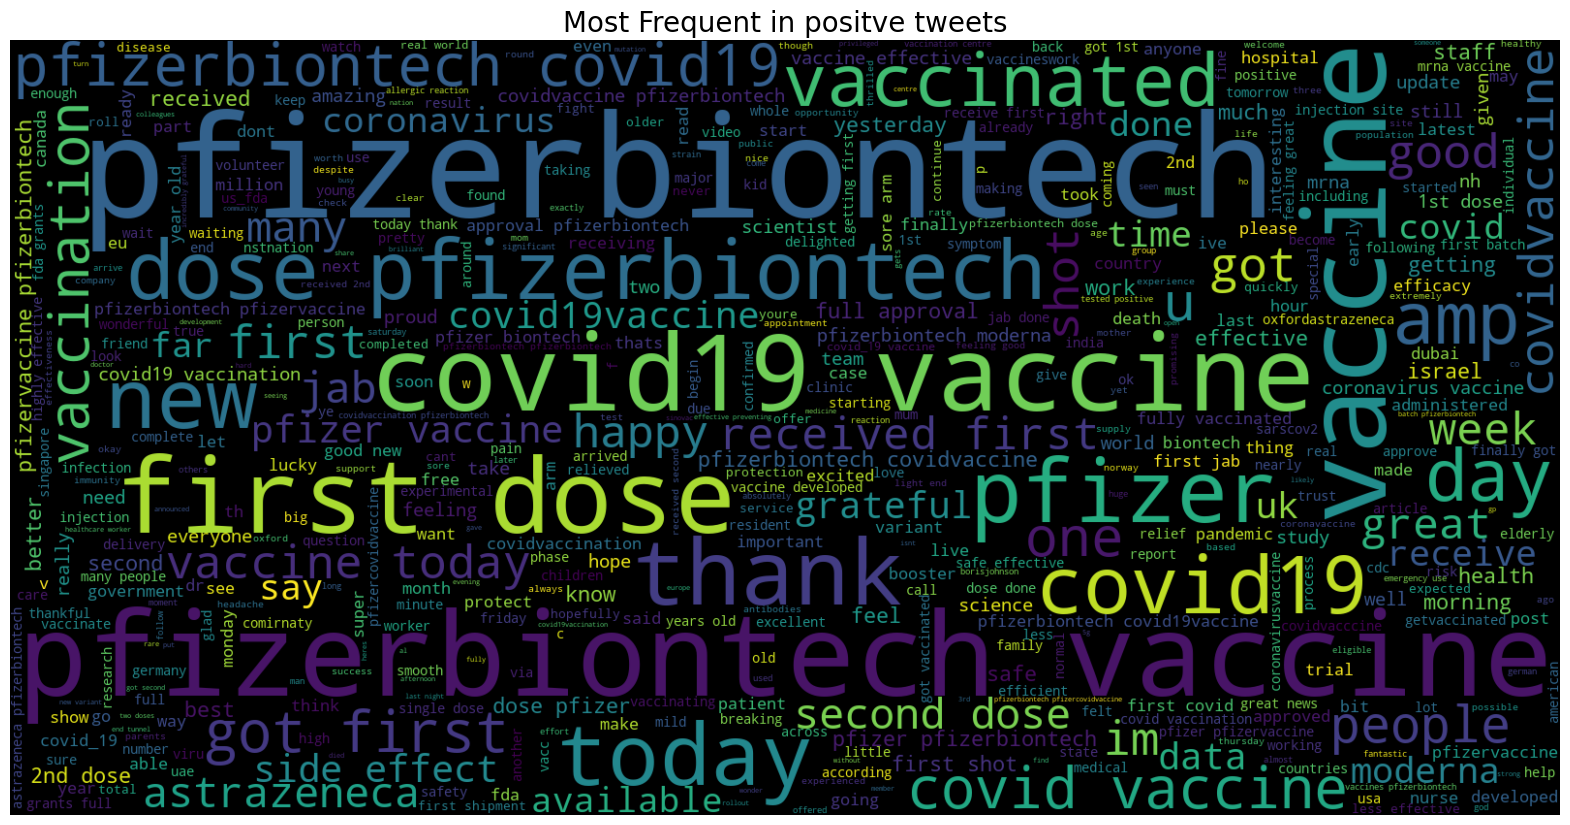

In [152]:
text=' '.join([word for word in pos_tweet['text']])
plt.figure(figsize=(20,15),facecolor='None')
wordcloud=WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent in positve tweets',fontsize=20)
plt.show()

In [153]:
neg_tweets=pos_tweet=df[df.sentiment=='Negative']
pos_tweet=pos_tweet.sort_values(['polarity'],ascending=False)
pos_tweet.head()

,text,polarity,sentiment
2912,work skilled nursing facility got first vaccin...,-0.003333,Negative
7256,200321 752308 vaccinations new daily record da...,-0.003409,Negative
2073,ukgovernment cant even vaccinate properly ethi...,-0.004762,Negative
7715,got first dose less waiting time airport vacci...,-0.005556,Negative
7157,nas_k27 second dose due end next month well fa...,-0.006250,Negative


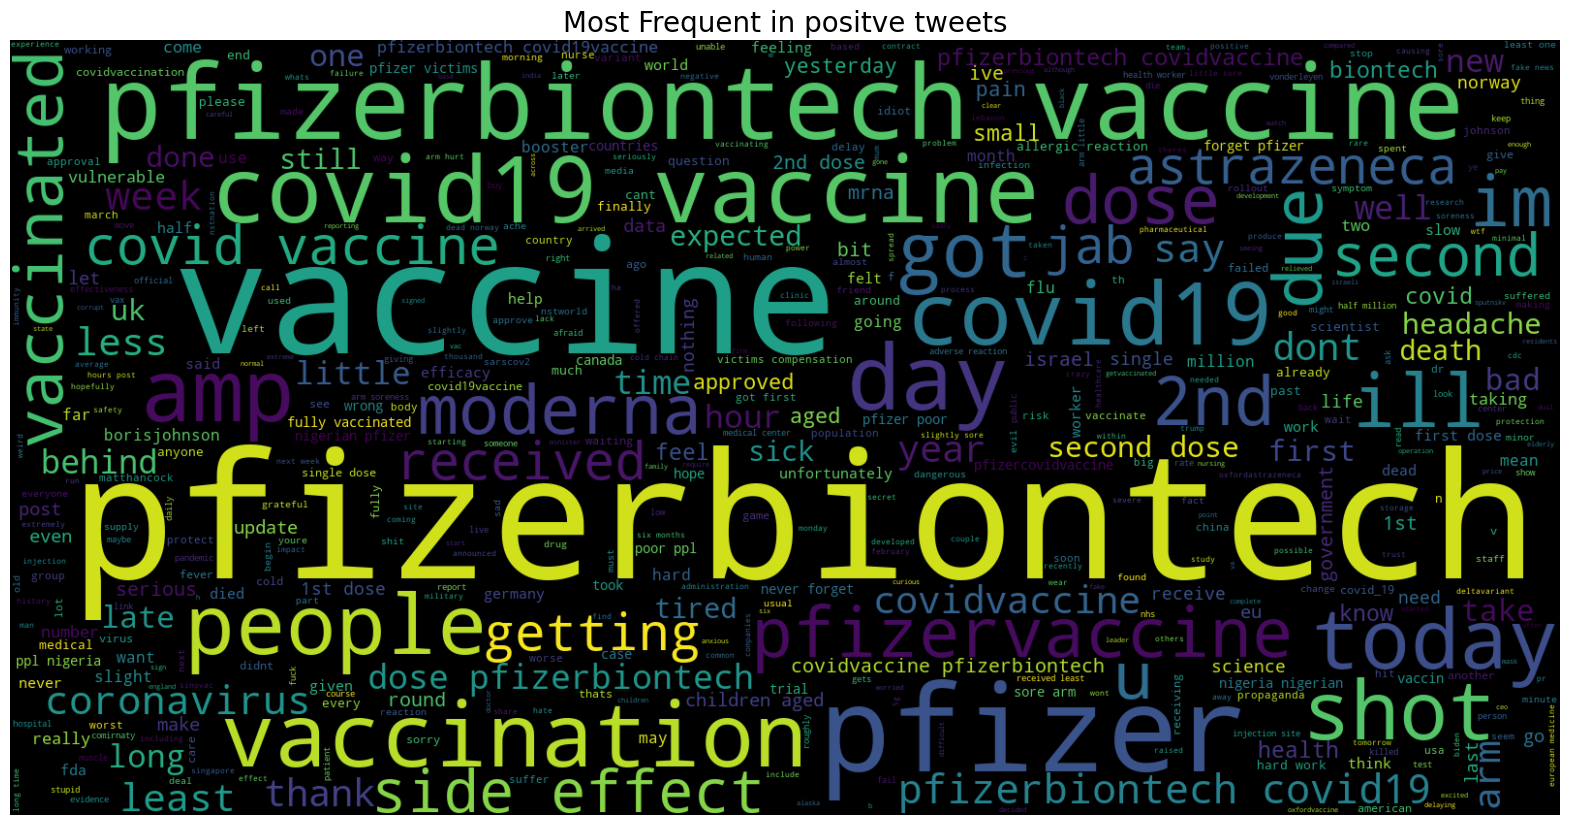

In [155]:
text=' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15),facecolor='None')
wordcloud=WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent in positve tweets',fontsize=20)
plt.show()

In [156]:
neutral_tweet=df[df.sentiment=='Neutral']
neutral_tweet=neutral_tweet.sort_values(['polarity'],ascending=False)
neutral_tweet.head()

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.0,Neutral
7347,anyone else feel like framing vaccine card pfi...,0.0,Neutral
7458,looking forward getting second pfizer shot any...,0.0,Neutral
7454,never thought id running diff vaccine modernav...,0.0,Neutral
7453,john___m dont get choose one person know asked...,0.0,Neutral


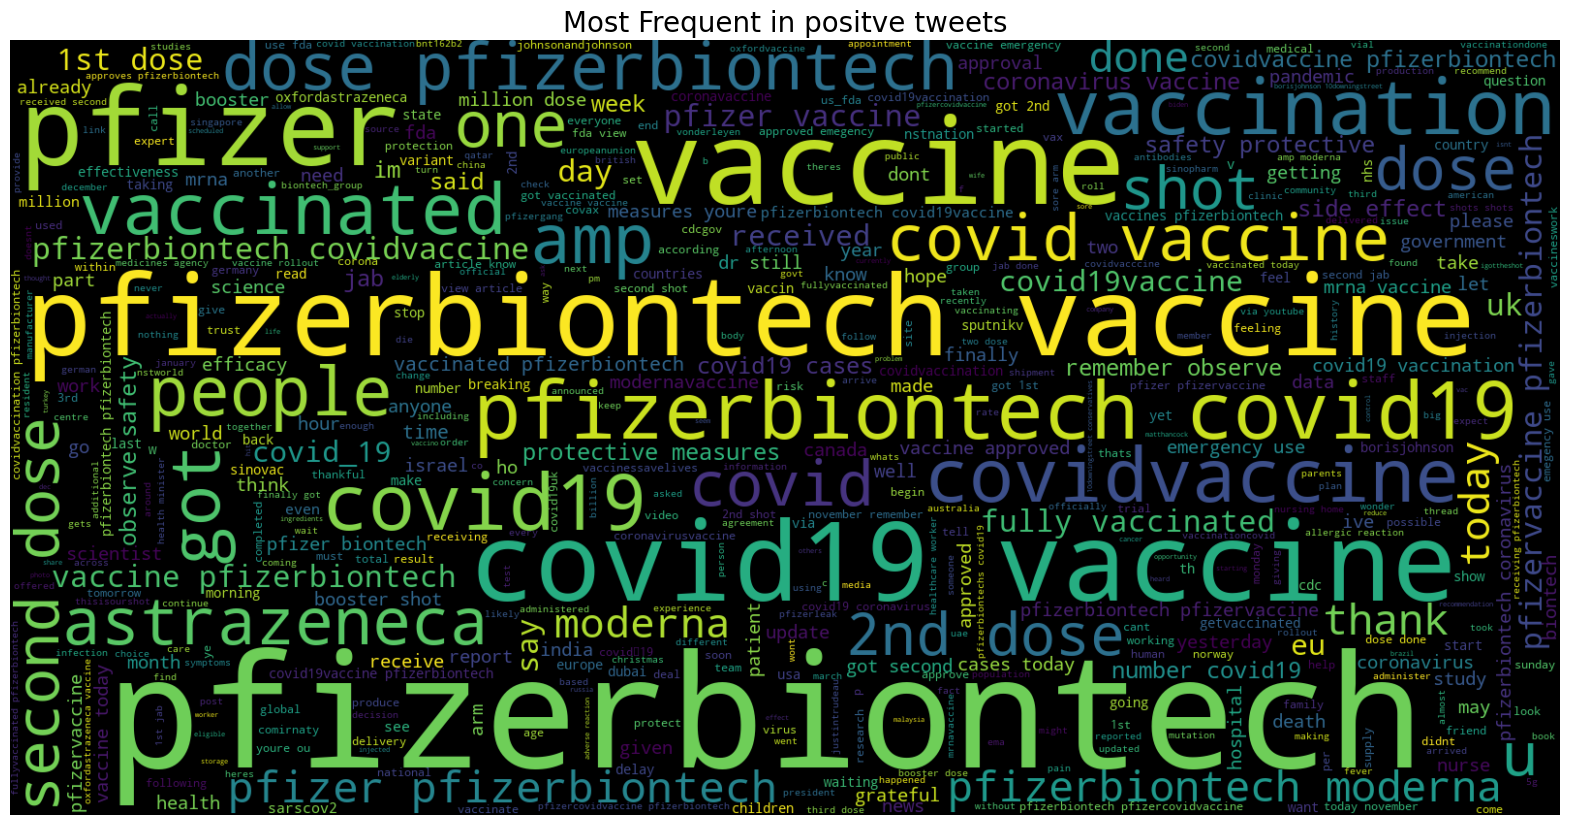

In [157]:
text=' '.join([word for word in neutral_tweet['text']])
plt.figure(figsize=(20,15),facecolor='None')
wordcloud=WordCloud(max_words=500,width=1600,height=800).generate(text)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent in positve tweets',fontsize=20)
plt.show()

## Text Vectorization

In [163]:
vect=CountVectorizer(ngram_range=(1,2))
vector=vect.fit(df['text'])


CountVectorizer(ngram_range=(1, 2))


In [166]:
feature_names= vect.get_feature_names_out()
print('Number of Features:{}\n'.format(len(feature_names)))
print('First 20 features:\n {}'.format(feature_names[:20]))

Number of Features:78583

First 20 features:
 ['000' '000 doses' '000 initial' '000 people' '000 vaccines' '0000001'
 '0000001 covid19' '0011' '0011 abt' '004' '004 covid' '004 israelis' '01'
 '01 getting' '01 june' '01 november' '01aug2021' '01aug2021 doublevaxxed'
 '02' '02 175']


In [168]:
x=df['text']
y=df['sentiment']
X=vect.transform(x)

In [171]:
X

<10543x78583 sparse matrix of type '<class 'numpy.int64'>'
	with 195505 stored elements in Compressed Sparse Row format>

In [175]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [176]:
print('size of x_train:',(x_train.shape))
print('size of x_test:',(x_test.shape))
print('size of y_train:',(y_train.shape))
print('size of y_test:',(x_test.shape))

size of x_train: (8434, 78583)
size of x_test: (2109, 78583)
size of y_train: (8434,)
size of y_test: (2109, 78583)


In [177]:
import warnings
warnings.filterwarnings('ignore')

## Model Building

In [184]:
logreg=LogisticRegression()
logreg.fit(x_train,y_train)
logreg_pred=logreg.predict(x_test)
logreg_acc=accuracy_score(logreg_pred,y_test)
print('Test accuracy: {:2f}%'.format(logreg_acc*100))

Test accuracy: 84.637269%


In [188]:
print(confusion_matrix(y_test,logreg_pred))
print('\n')
print(classification_report(y_test,logreg_pred))

[[  72  116   38]
 [   4 1008    9]
 [   8  149  705]]


              precision    recall  f1-score   support

    Negative       0.86      0.32      0.46       226
     Neutral       0.79      0.99      0.88      1021
    Positive       0.94      0.82      0.87       862

    accuracy                           0.85      2109
   macro avg       0.86      0.71      0.74      2109
weighted avg       0.86      0.85      0.83      2109



In [189]:
from sklearn.model_selection import GridSearchCV

In [191]:
param_grid={'C':[0.001,0.01,0.1,1,10]}
grid=GridSearchCV(LogisticRegression(),param_grid)
grid.fit(x_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [192]:
print('Best parameter:',grid.best_params_)

Best parameter: {'C': 10}


In [193]:
y_pred=grid.predict(x_test)

In [195]:
logreg_acc=accuracy_score(y_pred,y_test)
print('Test accuracy: {:.2f}%'.format(logreg_acc*100))

Test accuracy: 85.92%


In [197]:
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

[[  84  104   38]
 [   4 1008    9]
 [  10  132  720]]


              precision    recall  f1-score   support

    Negative       0.86      0.37      0.52       226
     Neutral       0.81      0.99      0.89      1021
    Positive       0.94      0.84      0.88       862

    accuracy                           0.86      2109
   macro avg       0.87      0.73      0.76      2109
weighted avg       0.87      0.86      0.85      2109

